In [0]:
!pip install yfinance
!pip install confluent-kafka

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# Databricks notebook source
import pyspark.sql.functions as F
from  pyspark.sql.functions import col, struct, to_json, lag, when, mean, stddev, expr, udf, row_number
from pyspark.sql.types import StructField, StructType, StringType, MapType, DoubleType, FloatType, IntegerType
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter
import json
import yfinance as yf
import pandas as pd
from datetime import date
from confluent_kafka import Producer

In [0]:
start_date = '2019-01-01'
end_date = date.today()

def getDatafromAPI():
    # ETF = [
    # 'QQQ', 'SPY', 'DIA', 'IWM', 'KWEB', 'AXP', 'XLK', 'XLY', 'XLP', 'XLU',
    # 'XLI', 'XLE', 'XLF', 'XLV', 'XLC'
    # ]
    ETF = ['AXP', 'DIA', 'IWM', 'KWEB', 'QQQ', 'SPY']
    ETFInformation = yf.download(tickers=ETF, start=start_date, end=end_date, interval='1d')

    return ETFInformation

def stream_data():

    ETFInformation = getDatafromAPI()
    technical = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    ETF_reorder = ['AXP', 'DIA', 'IWM', 'KWEB', 'QQQ', 'SPY']
    data = {}
    row_num = ETFInformation.shape[0]
    ETF_num = len(ETF_reorder)
    index = 0
    data_list = []
    for row_index in range(row_num):
        for index in range(ETF_num):
            data['Date'] = ETFInformation.iloc[row_index, :].name.strftime("%Y-%m-%d %H:%M:%S")
            data['ETF'] = ETF_reorder[index]
            data['Key'] = data['Date'] + ' ' + data['ETF']
            for i in range(len(technical)):
                data[technical[i]] = float(ETFInformation.iloc[row_index, index + i * ETF_num])

            # change int64 to int before serialization
            data[technical[-1]] = int(data[technical[-1]])
            # data_value = json.dumps(data).encode('utf-8')
            data_reformat = tuple([value for value in data.values()])
            # print(data_reformat)
            data_list.append(data_reformat)

    return data_list


In [0]:
def send_data_to_kafka(producer, topic, data_list):
    for data_tuple in data_list:
        # Serialize the data tuple to JSON format before sending
        data_json = json.dumps(data_tuple)
        # Produce the JSON data to the Kafka topic
        producer.produce(topic=topic, value=data_json)
    # Wait for any outstanding messages to be delivered and delivery reports to be received
    producer.flush()

In [0]:
# create producer
producer_config = {
    'bootstrap.servers': 'pkc-ygz0p.norwayeast.azure.confluent.cloud:9092',
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms': 'PLAIN',
    'sasl.username': 'EX46BPNQGO7BVLV4',
    'sasl.password': 'xi7tD+bbb+HVIrkQJU5gUv5pYBpijaDCNjtncHOrc1zOUQK1nPyxYLe11ddvXQWY',
    # Add other necessary configurations here
}

p = Producer(producer_config)

# write to Kafka topic
topic_name = 'assets'
data_list = stream_data()
send_data_to_kafka(p, topic_name, data_list)


[*********************100%%**********************]  6 of 6 completed


In [0]:
#read from topic
dfread = spark \
      .read \
      .format("kafka") \
      .option("kafka.bootstrap.servers", "pkc-ygz0p.norwayeast.azure.confluent.cloud:9092") \
      .option("subscribe", "assets") \
      .option("startingOffsets", "earliest") \
      .option("endingOffsets", "latest")  \
      .option("kafka.security.protocol","SASL_SSL") \
      .option("kafka.sasl.mechanism", "PLAIN") \
      .option("kafka.sasl.jaas.config", """kafkashaded.org.apache.kafka.common.security.plain.PlainLoginModule required username="EX46BPNQGO7BVLV4" password="xi7tD+bbb+HVIrkQJU5gUv5pYBpijaDCNjtncHOrc1zOUQK1nPyxYLe11ddvXQWY";""") \
      .load()

display(dfread)

key value topic partition offset timestamp timestampType MjAyMy0wMS0yNiAwMDowMDowMCBBWFA= eyJEYXRlIjoiMjAyMy0wMS0yNiAwMDowMDowMCIsIkVURiI6IkFYUCIsIktleSI6IjIwMjMtMDEtMjYgMDA6MDA6MDAgQVhQIiwiQWRqIENsb3NlIjoxNTQuMTQwNiwiQ2xvc2UiOjE1NS44OCwiSGlnaCI6MTU4LjIzLCJMb3c= (truncated) assets 0 78013 2023-11-01T07:45:21.609Z 0 MjAxOS0wMS0wMiAwMDowMDowMCBBWFA= eyJEYXRlIjoiMjAxOS0wMS0wMiAwMDowMDowMCIsIkVURiI6IkFYUCIsIktleSI6IjIwMTktMDEtMDIgMDA6MDA6MDAgQVhQIiwiQWRqIENsb3NlIjo4OS4wODU2NSwiQ2xvc2UiOjk1LjY4LCJIaWdoIjo5Ni4yNywiTG93Ijo= (truncated) assets 0 78014 2023-11-01T07:45:21.609Z 0 MjAyMS0wOS0xNiAwMDowMDowMCBRUVE= eyJEYXRlIjoiMjAyMS0wOS0xNiAwMDowMDowMCIsIkVURiI6IlFRUSIsIktleSI6IjIwMjEtMDktMTYgMDA6MDA6MDAgUVFRIiwiQWRqIENsb3NlIjozNzMuMDE2NDgsIkNsb3NlIjozNzguMzEsIkhpZ2giOjM3OC45LCJMb3c= (truncated) assets 0 78015 2023-11-01T07:45:21.609Z 0 MjAyMC0wNS0xMSAwMDowMDowMCBJV00= eyJEYXRlIjoiMjAyMC0wNS0xMSAwMDowMDowMCIsIkVURiI6IklXTSIsIktleSI6IjIwMjAtMDUtMTEgMDA6MDA6MDAgSVdNIiwiQWRqIENsb3NlIjoxMjUuODc2Nzg1LCJDbG9zZSI6MTMxLjcsIkhpZ2giOjEzMi45NSwiTG8= (truncated) assets 0 78016 2023-11-01T07:45:21.609Z 0 MjAyMy0wMS0yNiAwMDowMDowMCBESUE= eyJEYXRlIjoiMjAyMy0wMS0yNiAwMDowMDowMCIsIkVURiI6IkRJQSIsIktleSI6IjIwMjMtMDEtMjYgMDA6MDA6MDAgRElBIiwiQWRqIENsb3NlIjozMzQuMjIwNzMsIkNsb3NlIjozMzkuMzYsIkhpZ2giOjMzOS40NiwiTG8= (truncated) assets 0 78017 2023-11-01T07:45:21.612Z 0 MjAxOS0wMS0wMiAwMDowMDowMCBESUE= eyJEYXRlIjoiMjAxOS0wMS0wMiAwMDowMDowMCIsIkVURiI6IkRJQSIsIktleSI6IjIwMTktMDEtMDIgMDA6MDA6MDAgRElBIiwiQWRqIENsb3NlIjoyMTEuOTQyNDcsIkNsb3NlIjoyMzMuMzYsIkhpZ2giOjIzNC4wLCJMb3c= (truncated) assets 0 78018 2023-11-01T07:45:21.612Z 0 MjAyMS0wOS0xNiAwMDowMDowMCBTUFk= eyJEYXRlIjoiMjAyMS0wOS0xNiAwMDowMDowMCIsIkVURiI6IlNQWSIsIktleSI6IjIwMjEtMDktMTYgMDA6MDA6MDAgU1BZIiwiQWRqIENsb3NlIjo0MzIuMjkyMywiQ2xvc2UiOjQ0Ny4xNywiSGlnaCI6NDQ4LjM2LCJMb3c= (truncated) assets 0 78019 2023-11-01T07:45:21.613Z 0 MjAyMy0wMS0yNiAwMDowMDowMCBJV00= eyJEYXRlIjoiMjAyMy0wMS0yNiAwMDowMDowMCIsIkVURiI6IklXTSIsIktleSI6IjIwMjMtMDEtMjYgMDA6MDA6MDAgSVdNIiwiQWRqIENsb3NlIjoxODYuNDcyOCwiQ2xvc2UiOjE4OC41NiwiSGlnaCI6MTg5Ljg1LCJMb3c= (truncated) assets 0 78020 2023-11-01T07:45:21.613Z 0 MjAyMS0wOS0xNyAwMDowMDowMCBBWFA= eyJEYXRlIjoiMjAyMS0wOS0xNyAwMDowMDowMCIsIkVURiI6IkFYUCIsIktleSI6IjIwMjEtMDktMTcgMDA6MDA6MDAgQVhQIiwiQWRqIENsb3NlIjoxNTkuMDY3MjksIkNsb3NlIjoxNjMuOTIsIkhpZ2giOjE2NC4yNSwiTG8= (truncated) assets 0 78021 2023-11-01T07:45:21.613Z 0 MjAxOS0wMS0wMiAwMDowMDowMCBJV00= eyJEYXRlIjoiMjAxOS0wMS0wMiAwMDowMDowMCIsIkVURiI6IklXTSIsIktleSI6IjIwMTktMDEtMDIgMDA6MDA6MDAgSVdNIiwiQWRqIENsb3NlIjoxMjYuNTA5NjksIkNsb3NlIjoxMzQuNjYsIkhpZ2giOjEzNS4xNywiTG8= (truncated) assets 0 78022 2023-11-01T07:45:21.613Z 0 MjAyMy0wMS0yNiAwMDowMDowMCBLV0VC eyJEYXRlIjoiMjAyMy0wMS0yNiAwMDowMDowMCIsIkVURiI6IktXRUIiLCJLZXkiOiIyMDIzLTAxLTI2IDAwOjAwOjAwIEtXRUIiLCJBZGogQ2xvc2UiOjM2LjE1LCJDbG9zZSI6MzYuMTUsIkhpZ2giOjM2LjE5LCJMb3ciOjM= (truncated) assets 0 78023 2023-11-01T07:45:21.613Z 0 MjAyMy0wMS0yNiAwMDowMDowMCBRUVE= eyJEYXRlIjoiMjAyMy0wMS0yNiAwMDowMDowMCIsIkVURiI6IlFRUSIsIktleSI6IjIwMjMtMDEtMjYgMDA6MDA6MDAgUVFRIiwiQWRqIENsb3NlIjoyOTIuMDYyNiwiQ2xvc2UiOjI5My4zNCwiSGlnaCI6MjkzLjUyLCJMb3c= (truncated) assets 0 78024 2023-11-01T07:45:21.613Z 0 MjAyMS0wOS0xNyAwMDowMDowMCBESUE= eyJEYXRlIjoiMjAyMS0wOS0xNyAwMDowMDowMCIsIkVURiI6IkRJQSIsIktleSI6IjIwMjEtMDktMTcgMDA6MDA6MDAgRElBIiwiQWRqIENsb3NlIjozMzIuMTk2MjMsIkNsb3NlIjozNDUuNjQsIkhpZ2giOjM0Ny43LCJMb3c= (truncated) assets 0 78025 2023-11-01T07:45:21.613Z 0 MjAyMy0wMS0yNiAwMDowMDowMCBTUFk= eyJEYXRlIjoiMjAyMy0wMS0yNiAwMDowMDowMCIsIkVURiI6IlNQWSIsIktleSI6IjIwMjMtMDEtMjYgMDA6MDA6MDAgU1BZIiwiQWRqIENsb3NlIjo0MDAuMzA2OTIsIkNsb3NlIjo0MDQuNzUsIkhpZ2giOjQwNC45MiwiTG8= (truncated) assets 0 78026 2023-11-01T07:45:21.613Z 0 MjAxOS0wMS0wMiAwMDowMDowMCBLV0VC eyJEYXRlIjoiMjAxOS0wMS0wMiAwMDowMDowMCIsIkVURiI6IktXRUIiLCJLZXkiOiIyMDE5LTAxLTAyIDAwOjAwOjAwIEtXRUIiLCJBZGogQ2xvc2UiOjM0LjgzOTk1LCJDbG9zZSI6MzcuNTMsIkhpZ2giOjM3LjcxLCJMb3c= (truncated) assets 0 78027 2023-11-01T07:45:21.613Z 0 MjAyMS0wOS0xNyAwMDowMDowMCBJV00= eyJEYXRlIj

In [0]:
json_schema = StructType([
    StructField("Date", StringType(), False),
    StructField("ETF", StringType(), False),
    StructField("Key", StringType(),False),
    StructField("Adj Close", FloatType(), False),
    StructField("Close", FloatType(), False),
    StructField("High", FloatType(), False),
    StructField("Low", FloatType(), False),
    StructField("Open", FloatType(), False),
    StructField("Volume", IntegerType(), False)
])


In [0]:
#display data from topic
df3 = dfread.withColumn('value', F.from_json(F.col('value').cast('string'), json_schema))  \
      .select(F.col("value.*")) 
df_without_nulls = df3.na.drop()
clean_df = df_without_nulls.dropDuplicates(["Key"]).orderBy(col("Date"))

display(clean_df)


Date ETF Key Adj Close Close High Low Open Volume 2019-01-02 00:00:00 AXP 2019-01-02 00:00:00 AXP 89.08565 95.68 96.27 93.77 93.91 4175400 2019-01-02 00:00:00 DIA 2019-01-02 00:00:00 DIA 211.94247 233.36 234.0 229.14 229.27 5319500 2019-01-02 00:00:00 IWM 2019-01-02 00:00:00 IWM 126.50969 134.66 135.17 131.54 132.17 27295100 2019-01-02 00:00:00 KWEB 2019-01-02 00:00:00 KWEB 34.83995 37.53 37.71 36.51 36.75 1718700 2019-01-02 00:00:00 QQQ 2019-01-02 00:00:00 QQQ 150.2429 154.88 155.75 150.88 150.99 58576700 2019-01-02 00:00:00 SPY 2019-01-02 00:00:00 SPY 231.49219 250.18 251.21 245.95 245.98 126925200 2019-01-03 00:00:00 AXP 2019-01-03 00:00:00 AXP 87.34676 93.43 95.18 93.23 94.79 4776600 2019-01-03 00:00:00 DIA 2019-01-03 00:00:00 DIA 205.91185 226.72 231.42 226.36 231.25 7350200 2019-01-03 00:00:00 IWM 2019-01-03 00:00:00 IWM 124.245575 132.25 134.64 131.65 133.91 29294600 2019-01-03 00:00:00 KWEB 2019-01-03 00:00:00 KWEB 33.605286 36.2 37.08 36.03 36.94 1797900 2019-01-03 00:00:00 QQQ 2019-01-03 00:00:00 QQQ 145.33443 149.82 153.26 149.49 152.6 74820200 2019-01-03 00:00:00 SPY 2019-01-03 00:00:00 SPY 225.96819 244.21 248.57 243.67 248.23 144140700 2019-01-04 00:00:00 AXP 2019-01-04 00:00:00 AXP 91.28264 97.64 98.35 94.9 95.37 4637200 2019-01-04 00:00:00 DIA 2019-01-04 00:00:00 DIA 212.77795 234.28 235.18 229.73 230.0 7343700 2019-01-04 00:00:00 IWM 2019-01-04 00:00:00 IWM 128.8865 137.19 137.6 133.71 133.92 35355300 2019-01-04 00:00:00 KWEB 2019-01-04 00:00:00 KWEB 35.601177 38.35 38.85 37.16 37.22 2236900 2019-01-04 00:00:00 QQQ 2019-01-04 00:00:00 QQQ 151.55249 156.23 157.0 151.74 152.34 74709300 2019-01-04 00:00:00 SPY 2019-01-04 00:00:00 SPY 233.53717 252.39 253.11 247.17 247.59 142628800 2019-01-07 00:00:00 AXP 2019-01-07 00:00:00 AXP 91.77812 98.17 98.92 97.02 97.77 3289000 2019-01-07 00:00:00 DIA 2019-01-07 00:00:00 DIA 213.7589 235.36 236.88 232.95 234.84 5101600 2019-01-07 00:00:00 IWM 2019-01-07 00:00:00 IWM 131.14128 139.59 140.37 136.74 137.26 30477900 2019-01-07 00:00:00 KWEB 2019-01-07 00:00:00 KWEB 36.473804 39.29 39.375 38.4 38.68 3087800 2019-01-07 00:00:00 QQQ 2019-01-07 00:00:00 QQQ 153.3568 158.09 158.86 156.11 156.62 52059300 2019-01-07 00:00:00 SPY 2019-01-07 00:00:00 SPY 235.37851 254.38 255.95 251.69 252.69 103139100 2019-01-08 00:00:00 AXP 2019-01-08 00:00:00 AXP 92.22689 98.65 99.52 97.52 98.69 3227200 2019-01-08 00:00:00 DIA 2019-01-08 00:00:00 DIA 216.08394 237.92 238.66 235.79 237.94 4845800 2019-01-08 00:00:00 IWM 2019-01-08 00:00:00 IWM 133.1518 141.73 141.79 139.39 140.8 27320900 2019-01-08 00:00:00 KWEB 2019-01-08 00:00:00 KWEB 36.603764 39.43 39.65 38.64 39.56 1338700 2019-01-08 00:00:00 QQQ 2019-01-08 00:00:00 QQQ 154.744 159.52 160.11 157.2 159.54 49388700 2019-01-08 00:00:00 SPY 2019-01-08 00:00:00 SPY 237.59 256.77 257.31 254.0 256.82 102512600 2019-01-09 00:00:00 AXP 2019-01-09 00:00:00 AXP 92.39517 98.83 99.59 98.15 98.74 2954500 2019-01-09 00:00:00 DIA 2019-01-09 00:00:00 DIA 216.99213 238.92 239.88 237.78 238.93 4872000 2019-01-09 00:00:00 IWM 2019-01-09 00:00:00 IWM 134.25095 142.9 143.39 141.62 142.22 25764600 2019-01-09 00:00:00 KWEB 2019-01-09 00:00:00 KWEB 37.81058 40.73 41.01 39.83 40.01 4525000 2019-01-09 00:00:00 QQQ 2019-01-09 00:00:00 QQQ 156.00508 160.82 161.52 159.47 160.14 46491700 2019-01-09 00:00:00 SPY 2019-01-09 00:00:00 SPY 238.70035 257.97 258.91 256.19 257.56 95006600 2019-01-10 00:00:00 AXP 2019-01-10 00:00:00 AXP 91.862274 98.26 98.67 97.82 98.45 3523800 2019-01-10 00:00:00 DIA 2019-01-10 00:00:00 DIA 217.97304 240.0 240.16 237.04 237.64 3052200 2019-01-10 00:00:00 IWM 2019-01-10 00:00:00 IWM 134.94614 143.64 143.72 141.35 142.06 22896800 2019-01-10 00:00:00 KWEB 2019-01-10 00:00:00 KWEB 37.959118 40.89 40.945 39.97 40.24 1663600 2019-01-10 00:00:00 QQQ 2019-01-10 00:00:00 QQQ 156.4513 161.28 161.37 158.7 159.6 38943400 2019-01-10 00:00:00 SPY 2019-01-10 00:00:00 SPY 239.54237 258.88 259.16 255.5 256.26 96823900 2019-01-11 00:00:00 AXP 2019-01-11 00:00:00 AXP 92

In [0]:
# Define a function to calculate ROC
def calculate_roc(close_prices):
    return ((close_prices[-1] - close_prices[0]) / close_prices[0]) * 100

# Define a UDF for ROC calculation
calculate_roc_udf = udf(calculate_roc, DoubleType())

# Calculate ROC using the UDF and a window function
windowSpec = Window.partitionBy("ETF").orderBy("Date").rowsBetween(-9, 0)
clean_df = clean_df.withColumn("ROC", calculate_roc_udf(F.collect_list(col("Adj Close")).over(windowSpec)))
clean_df.show()
# Calculate other technical indicators and perform further operations as needed
# ...


+-------------------+---+--------------------+---------+------+------+------+------+-------+-------------------+
|               Date|ETF|                 Key|Adj Close| Close|  High|   Low|  Open| Volume|                ROC|
+-------------------+---+--------------------+---------+------+------+------+------+-------+-------------------+
|2019-01-02 00:00:00|AXP|2019-01-02 00:00:...| 89.08565| 95.68| 96.27| 93.77| 93.91|4175400|                0.0|
|2019-01-03 00:00:00|AXP|2019-01-03 00:00:...| 87.34676| 93.43| 95.18| 93.23| 94.79|4776600|-1.9519238164011994|
|2019-01-04 00:00:00|AXP|2019-01-04 00:00:...| 91.28264| 97.64| 98.35|  94.9| 95.37|4637200|  2.466155914452744|
|2019-01-07 00:00:00|AXP|2019-01-07 00:00:...| 91.77812| 98.17| 98.92| 97.02| 97.77|3289000| 3.0223435966221084|
|2019-01-08 00:00:00|AXP|2019-01-08 00:00:...| 92.22689| 98.65| 99.52| 97.52| 98.69|3227200| 3.5260932217281113|
|2019-01-09 00:00:00|AXP|2019-01-09 00:00:...| 92.39517| 98.83| 99.59| 98.15| 98.74|2954500|  3.

[*********************100%%**********************]  1 of 1 completed


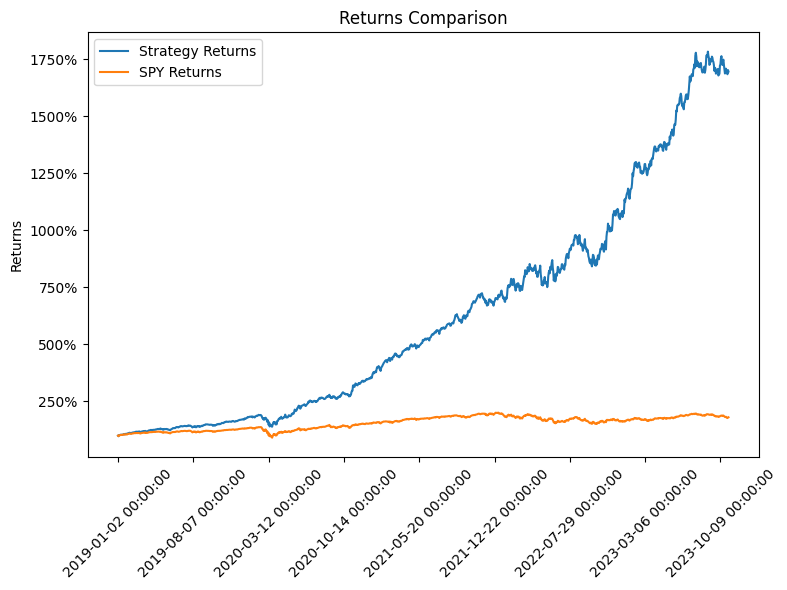

In [0]:
# Define a window specification to get the previous day's close price
windowSpec = Window.partitionBy("ETF").orderBy("Date")

# Calculate daily returns
clean_df = clean_df.withColumn("PrevClose", lag("Adj Close", 1).over(windowSpec))
clean_df = clean_df.withColumn("DailyReturn", (col("Adj Close")) / col("PrevClose"))

# Define a window specification for ROC calculation (last 10 days)
rocWindowSpec = Window.partitionBy("ETF").orderBy("Date").rowsBetween(-9, 0)
clean_df = clean_df.withColumn("ROC", ((col("Adj Close")) / lag("Adj Close", 10).over(windowSpec)))

# Define a window specification for getting top 3 ETFs based on ROC
rocRankSpec = Window.partitionBy("Date").orderBy(col("ROC").desc())
top3_df = clean_df.withColumn("rank", row_number().over(rocRankSpec)).filter(col("rank") <= 3)

# Calculate monthly portfolio returns based on top 3 ETFs with highest ROC
monthlyPortfolioReturns = top3_df.groupby("Date").agg({"DailyReturn": "avg"}).withColumnRenamed("avg(DailyReturn)", "PortfolioReturn")

# Fill missing values with 1.0 (indicating no change in portfolio)
monthlyPortfolioReturns = monthlyPortfolioReturns.na.fill(1.0)
res = monthlyPortfolioReturns.toPandas()

tmp = yf.download(tickers=['SPY'], start=start_date, end=end_date, interval='1d')['Adj Close'].pct_change() + 1
tmp[:1] = 1.0
tmp_df=tmp.to_frame(name="SPY Returns")
tmp_df.index = tmp_df.index.strftime("%Y-%m-%d %H:%M:%S")


# Plot the strategy returns and SPY returns
plt.figure(figsize=(8, 6))
plt.plot(res['PortfolioReturn'].cumprod(), label='Strategy Returns')
plt.plot(tmp_df['SPY Returns'].cumprod(), label='SPY Returns')
plt.ylabel('Returns')
plt.title('Returns Comparison')
plt.xticks(rotation=45)

# Define a custom formatter to display y-axis ticks in percentage form
def percentage_formatter(x, pos):
    return '{:.0%}'.format(x)

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
plt.legend()
plt.tight_layout()
plt.show()